In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 2.7MB/s 


In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
df1=pd.read_csv('/content/drive/My Drive/SPARKS INTERNSHIP/News.csv')
df2=pd.read_csv('/content/drive/My Drive/SPARKS INTERNSHIP/sensex_data.csv')

In [ ]:
df1.head() 
#Label 0= Down
#Label 1= Up


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [ ]:
df2.head() #Sensex data values

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-08-08,15036.570313,15228.820313,14888.120117,15167.820313,15167.820313,21000.0
1,2008-08-11,15430.309570,15520.709961,15367.969727,15503.919922,15503.919922,26200.0
2,2008-08-12,15577.200195,15579.780273,15124.910156,15212.129883,15212.129883,27000.0
3,2008-08-13,15030.209961,15272.559570,15013.059570,15093.120117,15093.120117,19200.0
4,2008-08-14,15017.679688,15033.280273,14686.660156,14724.179688,14724.179688,22000.0


In [ ]:
df2.shape
#df1.shape

(1947, 7)

In [ ]:
merge=df1.merge(df2, how='inner', on='Date', left_index=True)
merge

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Adj Close,Volume
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",15036.570313,15228.820313,14888.120117,15167.820313,15167.820313,21000.0
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",15430.309570,15520.709961,15367.969727,15503.919922,15503.919922,26200.0
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | As

In [ ]:
#Combine all news headlines into one column
headlines =[]
 
for row in range(0, len(merge.index)):
  headlines.append(''.join(str(x) for x in merge.iloc[row, 2:27]))


In [ ]:
headlines[0] # similarly all headlines are converted

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"b\'BREAKING: Musharraf to be impeached.\'b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\'b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\'b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing"b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\'b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side"b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it."b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\'b\'Did the U.S. Prep Georgia for War with Russia?\'b\'Rice G

In [ ]:
#Preprocess this data to obtain better accuracy
preprocessed_headlines=[]

for i in range(0,len(headlines)):
  preprocessed_headlines.append(re.sub("b[(')]",'', headlines[i]))
  preprocessed_headlines[i] = re.sub('b[(")]','', preprocessed_headlines[i])
  preprocessed_headlines[i]=re.sub("\'",'',preprocessed_headlines[i])

In [ ]:
preprocessed_headlines[0] #cleaned dataset

'Georgia downs two Russian warplanes as countries move to brink of war"BREAKING: Musharraf to be impeached.Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fireAfghan children raped with impunity, U.N. official says - this is sick, a three year old was raped and they do nothing"150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SOs side"The enemy combatent trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it."Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]Did the U.S. Prep Georgia for War with Russia?Rice Gives Green Light for Israel to Attack Iran: Says U.S. h

In [ ]:
#merge the preprocessed headlines to the original dataset
merge['Combined_News'] = preprocessed_headlines
merge

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Adj Close,Volume,Combined_News
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",15036.570313,15228.820313,14888.120117,15167.820313,15167.820313,21000.0,Georgia downs two Russian warplanes as countri...
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",15430.309570,15520.709961,15367.969727,15503.919922,15503.919922,26200.0,Why wont America and Nato help us? If they won...
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US enc

In [ ]:
#Function to get Polarity and Subjectivity
#Polarity 1:- Positive
#Polarity 0:- Negative
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
#Add two new columns to the merged dataset
merge['Subjectivity']= merge['Combined_News'].apply(getSubjectivity)
merge['Polarity']= merge['Combined_News'].apply(getPolarity)

In [ ]:
merge.head(5)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Adj Close,Volume,Combined_News,Subjectivity,Polarity
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",15036.570313,15228.820313,14888.120117,15167.820313,15167.820313,21000.0,Georgia downs two Russian warplanes as countri...,0.277104,-0.050303
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",15430.309570,15520.709961,15367.969727,15503.919922,15503.919922,26200.0,Why wont America and Nato help us? If they won...,0.365960,0.082481
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georg

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid= SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
merge['score']= merge['Combined_News'].apply(lambda Combined_News : sid.polarity_scores(Combined_News))


In [ ]:
merge.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Adj Close,Volume,Combined_News,Subjectivity,Polarity,score
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",15036.570313,15228.820313,14888.120117,15167.820313,15167.820313,21000.0,Georgia downs two Russian warplanes as countri...,0.277104,-0.050303,"{'neg': 0.214, 'neu': 0.724, 'pos': 0.062, 'co..."
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",15430.309570,15520.709961,15367.969727,15503.919922,15503.919922,26200.0,Why wont America and Nato help us? If they won...,0.365960,0.082481,"{'neg': 0.148, 'neu': 0.761, 'pos': 0.091, 'co..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ..."

In [ ]:
merge['Compound']= merge['score'].apply(lambda score_dict: score_dict['compound'])
merge['Positive']= merge['score'].apply(lambda score_dict: score_dict['pos'])
merge['Negative']= merge['score'].apply(lambda score_dict: score_dict['compound'])
merge['Neutral']= merge['score'].apply(lambda score_dict: score_dict['neu'])
merge.head()


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Adj Close,Volume,Combined_News,Subjectivity,Polarity,score,Compound,Positive,Negative,Neutral
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",15036.570313,15228.820313,14888.120117,15167.820313,15167.820313,21000.0,Georgia downs two Russian warplanes as countri...,0.277104,-0.050303,"{'neg': 0.214, 'neu': 0.724, 'pos': 0.062, 'co...",-0.9966,0.062,-0.9966,0.724
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",15430.309570,15520.709961,15367.969727,15503.919922,15503.919922,26200.0,Why wont America and Nato help us? If they won...,0.365960,0.082481,"{'neg': 0.148, 'neu': 0.761, 'pos': 0.091, 'co...",-0.9457,0.091,-0.9457,0.761
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why 

In [ ]:
#Keep necessary columns
keep_columns = ['Open', 'High','Date', 'Low','Close', 'Volume', 'Subjectivity','Polarity','Compound','Negative', 'Neutral','Positive','Label']
df=merge[keep_columns]
df=df.replace(np.nan,0)
df


,Open,High,Date,Low,Close,Volume,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Label
0,15036.570313,15228.820313,2008-08-08,14888.120117,15167.820313,21000.0,0.277104,-0.050303,-0.9966,-0.9966,0.724,0.062,0
1,15430.309570,15520.709961,2008-08-11,15367.969727,15503.919922,26200.0,0.365960,0.082481,-0.9457,-0.9457,0.761,0.091,1
2,15577.200195,15579.780273,2008-08-12,15124.910156,15212.129883,27000.0,0.536257,-0.058650,-0.9739,-0.9739,0.805,0.056,0
3,15030.209961,15272.559570,2008-08-13,15013.059570,15093.120117,19200.0,0.353922,-0.004739,-0.9805,-0.9805,0.797,0.058,0
4,15017.679688,15033.280273,2008-08-14,14686.660156,14724.179688,22000.0,0.384127,0.026930,-0.9831,-0.9831,0.723,0.092,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,26367.480469,26435.849609,2016-06-24,25911.330078,26397.710938,24400.0,0.363095,0.010873,-0.9133,-0.9133,0.870,0.041,0
1943,26347.810547,26493.509766,2016-06-27,26262.720703,26402.960938,18300.0,0.341564,-0.030999,-0.9730,-0.9730,0.754,0.090,0
1944,26410.660156,26583.330078,2016-06-28,26378.460938,26524.550781,8100.0,0.348121,0.039423,-0.9633,-0.9633,0.763,0.100,1
1945,26627.150391,26776.169922,2016-06-29,26606.310547,26740.390625,7700.0,0.406462,0.046901,-0.9962,-0.9962,0.707,0.086,1


In [ ]:
pip install matplotlib

TASK 4.2 ACTUAL PRICE PREDICTION OF STOCK SENSEX


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from sklearn.svm import SVR

In [2]:

df2=pd.read_csv('/content/drive/My Drive/SPARKS INTERNSHIP/sensex_recent_data.csv')
actual_price=df2.tail()
actual_price


,Date,Open,High,Low,Close,AClose,Volume
246,2020-10-12,40716.94922,40905.48828,40387.39844,40593.80078,40593.80078,17600.0
247,2020-10-13,40592.53906,40786.82031,40461.96875,40625.51172,40625.51172,11000.0
248,2020-10-14,40623.19141,40880.25000,40279.55078,40794.73828,40794.73828,15000.0
249,2020-10-15,41048.05078,41048.05078,39667.46875,39728.41016,39728.41016,30400.0
250,2020-10-16,39936.60938,40125.71094,39699.42188,39982.98047,39982.98047,0.0


In [5]:
#Data for training
df2=df2.head(len(df2)-4)
df2
#Last 5 rows are gone

,Date,Open,High,Low,Close,AClose,Volume
0,2019-10-16,38637.05078,38666.37891,38416.67188,38598.98828,38598.98828,27500.0
1,2019-10-17,38647.44141,39104.69141,38557.42969,39052.05859,39052.05859,47100.0
2,2019-10-18,39087.82813,39361.05859,38963.60156,39298.37891,39298.37891,42400.0
3,2019-10-22,39233.39844,39426.46875,38924.85156,38963.83984,38963.83984,54500.0
4,2019-10-23,39063.83984,39196.67188,38866.07813,39058.82813,39058.82813,41000.0
...,...,...,...,...,...,...,...
236,2020-09-25,36991.89063,37471.17188,36730.51953,37388.66016,37388.66016,13500.0
237,2020-09-28,37756.25000,38035.87109,37544.05078,37981.62891,37981.62891,13600.0
238,2020-09-29,38176.85938,38235.94141,37831.35156,37973.21875,37973.21875,10600.0
239,2020-09-30,38068.89063,38236.33984,37828.10938,38067.92969,38067.92969,18400.0


In [6]:
df2=df2.replace(np.nan,0)

In [7]:
#List to store dependent and independent
days = list()
adj_close_prices=list()

In [8]:
df_days = df2.loc[:,'Date']
df_adj_close =df2.loc[:,'AClose']

In [9]:
for adj_close_price in df_adj_close:
  adj_close_prices.append(float (adj_close_price))
for day in df_days:
   days.append ( [int (day.split('-')[1])])


In [ ]:
#days

In [10]:
# 3 Support Vector Regression Models
lin_svr = SVR(kernel='linear', C=2000.0)
lin_svr.fit(days, adj_close_prices)

poly_svr = SVR(kernel='poly', C=2000.0, degree=2)
poly_svr.fit(days, adj_close_prices)

rbf_svr = SVR(kernel='rbf', C=2000.0, gamma=0.20)
rbf_svr.fit(days, adj_close_prices)


SVR(C=2000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.2,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

[]

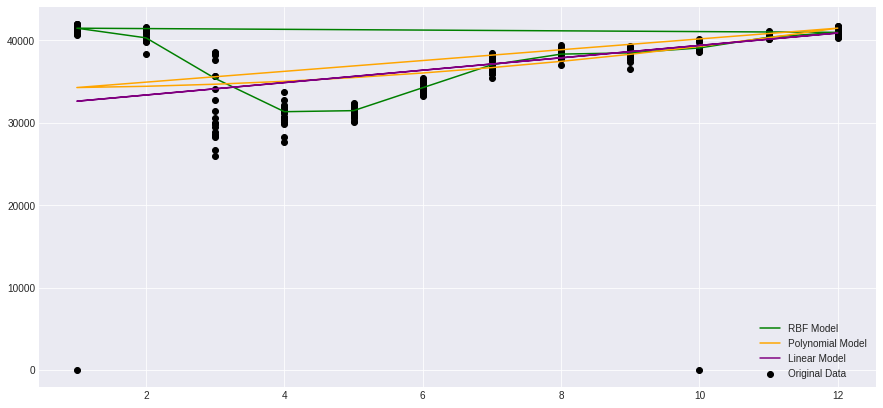

In [11]:
#Graphical representation to check best fit

plt.figure(figsize=(15,7)),
plt.scatter(days, adj_close_prices, color='black', label='Original Data')
plt.plot(days, rbf_svr.predict(days), color='green', label='RBF Model')
plt.plot(days, poly_svr.predict(days), color='orange', label='Polynomial Model')
plt.plot(days, lin_svr.predict(days), color='purple', label='Linear Model')
plt.legend()
plt.plot()

In [24]:
day=[12,13,14,15,16]
for i in day:
  print(i)
  print('The RBF SVR predicted for day1[i] ', rbf_svr.predict([[i]]))
 
print('Actual Price ',actual_price['AClose'].tolist())

12
The RBF SVR predicted for day1[i]  [40950.57602453]
13
The RBF SVR predicted for day1[i]  [40217.52826769]
14
The RBF SVR predicted for day1[i]  [39025.13427595]
15
The RBF SVR predicted for day1[i]  [38226.56659594]
16
The RBF SVR predicted for day1[i]  [37910.43817778]
Actual Price  [40593.80078, 40625.51172, 40794.73828, 39728.41016, 39982.98047]
